In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [28]:
df = pd.read_csv(r'C:\Users\Germán\Github\ProyectoFinal\data\vehiculos-de-segunda-mano-sample.csv')

## Duplicados

In [29]:
#ver cantidad de duplicados 
df.duplicated().sum()


np.int64(237)

In [30]:
# Eliminamos duplicados 
df = df.drop_duplicates()

In [31]:
print(df.shape)

(99763, 28)


In [32]:
#Mostrar nombres de cada columna en una lista
print(df.columns)


Index(['vehicle_type', 'make', 'model', 'version', 'fuel', 'year', 'kms',
       'power', 'doors', 'shift', 'color', 'photos', 'description', 'price',
       'currency', 'location', 'publish_date', 'update_date', 'dealer_name',
       'dealer_description', 'dealer_address', 'dealer_zip_code',
       'dealer_city', 'dealer_country_code', 'dealer_is_professional',
       'dealer_website', 'dealer_registered_at', 'date'],
      dtype='object')


Drop columns

In [33]:
# 'dealer_city', 'dealer_country_code'

In [34]:
#Drop 'vehicle_type','doors','color','photos', 'description','currency','update_date','dealer_description','dealer_address', 'dealer_zip_code','dealer_is_professional','dealer_city', 'dealer_country_code','dealer_website','dealer_registered_at', 'date'
df = df.drop(['dealer_name','vehicle_type','doors','color','photos', 'description','currency','update_date','dealer_description','dealer_is_professional','dealer_website','dealer_registered_at',"date"], axis=1)

In [35]:
df.duplicated().sum()


np.int64(57058)

In [36]:
df.drop_duplicates(inplace=True)

In [37]:
df.shape

(42705, 15)

## Nulls

In [48]:
#Mostramos los nulos en porcetaje con relacion al total por cada fila 
df.isnull().sum()/df.shape[0]*100

make                   0.0
model                  0.0
version                0.0
fuel                   0.0
year                   0.0
kms                    0.0
power                  0.0
shift                  0.0
price                  0.0
location               0.0
publish_date           0.0
dealer_address         0.0
dealer_zip_code        0.0
dealer_city            0.0
dealer_country_code    0.0
dtype: float64

### Drop nulls from version and kms

In [39]:
#Drop nuls de "verion", kms, power,dealer_name
df = df.dropna(subset=['version', 'kms',"dealer_address"])

### Fixing Fuel, Power and Shift nulls

In [40]:
#Lista de variables a rellenar
variables = ['fuel', 'power', 'shift']
 
# Función para calcular la moda o mediana por modelo
def calculate_stat_by_model(df, var):
    if var == 'power':
        return df.groupby('model')[var].transform(lambda x: x.median() if not pd.isna(x.median()) else None)
    else:
        return df.groupby('model')[var].transform(lambda x: x.mode()[0] if not x.mode().empty else None)
 
# Función para rellenar los valores nulos
def fill_missing_values(df, var):
    stat_by_model = calculate_stat_by_model(df, var)
    df[var] = df[var].fillna(stat_by_model)
    return df
 
# Aplicar la función para cada variable
for var in variables:
    df = fill_missing_values(df, var)

c:\Users\Germán\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [41]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
 
# Mostrar el resultado completo para 'shift'
shift_nulls = df[df['shift'].isnull()][['make', 'model']].value_counts()
print("Shift Nulls:")
print(shift_nulls)

# Mostrar el resultado completo para 'power'
power_nulls = df[df['power'].isnull()][['make', 'model']].value_counts()
print("\nPower Nulls:")
print(power_nulls)

# Mostrar el resultado completo para 'fuel'
fuel_nulls = df[df['fuel'].isnull()][['make', 'model']].value_counts()
print("\nFuel Nulls:")
print(fuel_nulls)

Shift Nulls:
make   model 
Lotus  Esprit    1
Name: count, dtype: int64

Power Nulls:
make     model  
Citroen  ë-Jumpy    1
Name: count, dtype: int64

Fuel Nulls:
make     model    
Ferrari  LaFerrari    1
Lotus    Esprit       1
Tata     Indigo       1
Name: count, dtype: int64


In [42]:
#Rellenamos citroen e-jumpy con 100
df.loc[(df['make'] == 'Citroen') & (df['model'] == 'ë-Jumpy'), 'power'] = 100

In [43]:
#Rellenamos Lotus Esprit con manual
df.loc[(df['make'] == 'Lotus') & (df['model'] == 'Esprit'), 'shift'] = "manual"

In [44]:
modelos = "LaFerrari","Indigo","Esprit"
df.loc[df['model'].isin(modelos), 'fuel'] = 'Gasolina'

# Dtypes

In [45]:
df.dtypes

make                    object
model                   object
version                 object
fuel                    object
year                     int64
kms                    float64
power                  float64
shift                   object
price                    int64
location                object
publish_date            object
dealer_address          object
dealer_zip_code        float64
dealer_city             object
dealer_country_code     object
dtype: object

In [46]:
#Publish date to datetime
df['publish_date'] = pd.to_datetime(df['publish_date'])

In [47]:
df.shape

(42355, 15)

# Getting coordinates

In [70]:
df_coordenadas = df[['dealer_address', 'dealer_city', 'dealer_country_code']]

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time

def clean_address(address):
    """
    Limpia y formatea la dirección
    """
    if pd.isna(address):
        return ""
    # Convertir a string si no lo es
    address = str(address)
    # Eliminar caracteres especiales y espacios extras
    address = address.replace("NaN", "").strip()
    return address

def get_coordinates(address, city, country_code):
    """
    Get latitude and longitude from address using Nominatim geocoder
    """
    # Limpiar los componentes de la dirección
    address = clean_address(address)
    city = clean_address(city)
    country_code = clean_address(country_code)
    
    # Si no hay suficiente información, retornar None
    if not (address and city and country_code):
        print(f"Información incompleta: {address}, {city}, {country_code}")
        return None, None
    
    # Crear la dirección completa
    full_address = f"{address}, {city}, {country_code}"
    print(f"Buscando dirección: {full_address}")  # Para depuración
    
    # Initialize the geocoder
    geolocator = Nominatim(user_agent="my_vehicles_app")
    
    try:
        time.sleep(1)  # Respetar límites de la API
        
        # Intentar primero con la dirección completa
        location = geolocator.geocode(full_address)
        
        # Si falla, intentar solo con ciudad y país
        if not location:
            print("Intentando con ciudad y país...")
            location = geolocator.geocode(f"{city}, {country_code}")
        
        if location:
            print(f"Encontrado: {location.latitude}, {location.longitude}")
            return location.latitude, location.longitude
        else:
            print("No se encontró la ubicación")
            return None, None
            
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        print(f"Error de geocodificación: {str(e)}")
        return None, None

def get_province_from_coordinates(lat, long):
    """
    Obtiene la provincia utilizando las coordenadas de latitud y longitud
    """
    if lat is None or long is None:
        return 'Unknown'
    
    geolocator = Nominatim(user_agent="my_vehicles_app")
    try:
        time.sleep(1)  # Respetar límites de la API
        location = geolocator.reverse((lat, long), timeout=10).raw['address']
        print(f"Provincia encontrada: {location.get('state', 'Unknown')}")  # 'state' puede variar dependiendo del país
        return location.get('state', 'Unknown')  # 'state' puede variar dependiendo del país
    except (GeocoderTimedOut, GeocoderServiceError, KeyError) as e:
        print(f"Error al obtener la provincia: {str(e)}")
        return 'Unknown'

def add_coordinates_and_state_to_df(df):
    """
    Add latitude, longitude, and state columns to the DataFrame
    """
    # Initialize new columns
    df['lat'] = None
    df['long'] = None
    df['state'] = None
    
    # Iterate through rows
    for idx, row in df.iterrows():
        print(f"\nProcesando fila {idx + 1}/{len(df)}")
        
        # Imprimir los valores para depuración
        print(f"Dirección: {row.get('dealer_address', 'No disponible')}")
        print(f"Ciudad: {row.get('dealer_city', 'No disponible')}")
        print(f"País: {row.get('dealer_country_code', 'No disponible')}")
        
        # Obtener latitud y longitud
        lat, long = get_coordinates(
            row.get('dealer_address', ''),
            row.get('dealer_city', ''),
            row.get('dealer_country_code', '')
        )
        
        # Obtener la provincia si se encontraron coordenadas
        state = get_province_from_coordinates(lat, long)
        
        # Actualizar el DataFrame
        df.at[idx, 'lat'] = lat
        df.at[idx, 'long'] = long
        df.at[idx, 'state'] = state
    
    return df


In [ ]:
# df_final = add_coordinates_and_state_to_df(df2)

Exportamos asi no tenemos que correr el codigo de arriba ya que tardo más de 15 horas en calcular las coordenadas


In [ ]:
# df_final.to_csv(r'C:\Users\Germán\Github\ProyectoFinal\data\dffinal', index=False)

In [49]:
df_final = pd.read_csv(r'C:\Users\Germán\Github\ProyectoFinal\data\dffinal.csv')

In [50]:
df_final.columns

Index(['make', 'model', 'version', 'fuel', 'year', 'kms', 'power', 'shift',
       'price', 'location', 'publish_date', 'dealer_address',
       'dealer_zip_code', 'dealer_city', 'dealer_country_code', 'lat', 'long',
       'state'],
      dtype='object')

In [51]:
df_final.shape

(42355, 18)

# EDA

In [56]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
year,42355.0,2016.688183,3.977171,1967.000000,2015.000000,2018.000000,2019.000000,2.023000e+03
kms,42355.0,86415.262566,56204.475595,0.000000,44000.000000,80799.000000,116712.000000,1.330000e+06
power,42355.0,152.095597,1752.963259,0.000000,102.000000,126.000000,150.000000,3.605710e+05
price,42355.0,19320.282729,16203.775595,0.000000,12089.000000,16290.000000,22500.000000,4.980000e+05
dealer_zip_code,42355.0,24565.356085,14623.304167,1002.000000,8734.000000,28230.000000,36211.000000,5.082000e+04
lat,38005.0,39.834778,1.963154,28.047874,37.992379,40.307064,41.382894,4.356887e+01
long,38005.0,-2.282374,3.090259,-16.622750,-3.993013,-2.886931,-0.287010,3.238264e+00


### Kms

In [57]:
#Generar una columna nueva diviendo los datos segun la cantidad de kms en 3 categorias
df_final['kms_category'] = pd.cut(df['kms'], bins=[0, 50000, 100000, 150000, float("inf")], labels=['Bajo', 'Medio', 'Alto', 'Muy Alto'])

#Mostrar la cantidad de autos por cada categoria
print(df_final['kms_category'].value_counts())

kms_category
Medio       5003
Bajo        4295
Alto        3583
Muy Alto    1822
Name: count, dtype: int64


C:\Users\Germán\AppData\Local\Temp\ipykernel_40560\599740204.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, x='kms_category', palette='viridis')


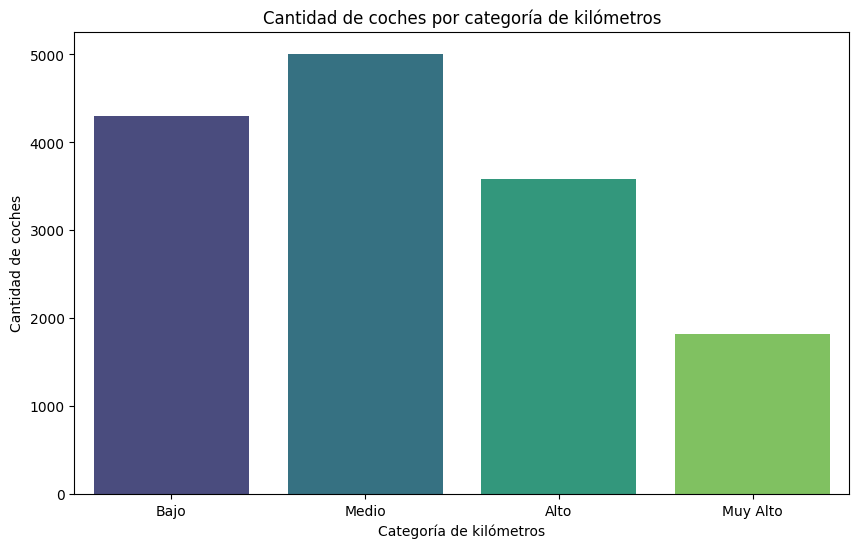

In [58]:
#Gráfico de barras de la cantidad de coches por cada categoria
plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='kms_category', palette='viridis')
plt.title('Cantidad de coches por categoría de kilómetros')
plt.xlabel('Categoría de kilómetros')
plt.ylabel('Cantidad de coches')
plt.show()

C:\Users\Germán\AppData\Local\Temp\ipykernel_40560\1674697458.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final, x='kms_category', y='price',palette='viridis')


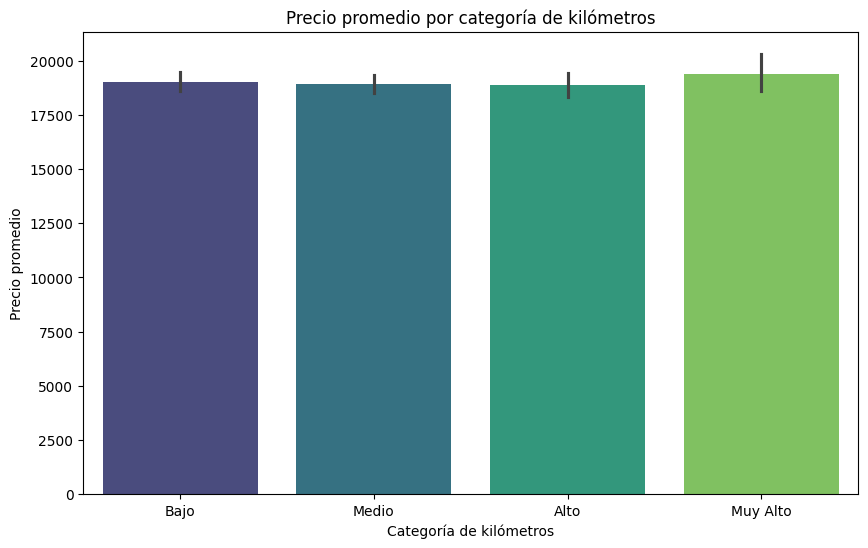

In [59]:
#Precio promedio segun categoria de kms.
plt.figure(figsize=(10, 6))
sns.barplot(data=df_final, x='kms_category', y='price',palette='viridis')
plt.title('Precio promedio por categoría de kilómetros')
plt.xlabel('Categoría de kilómetros')
plt.ylabel('Precio promedio')
plt.show()

### Fuel Type

C:\Users\Germán\AppData\Local\Temp\ipykernel_40560\732314301.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final, x='fuel', y='price',palette='viridis')


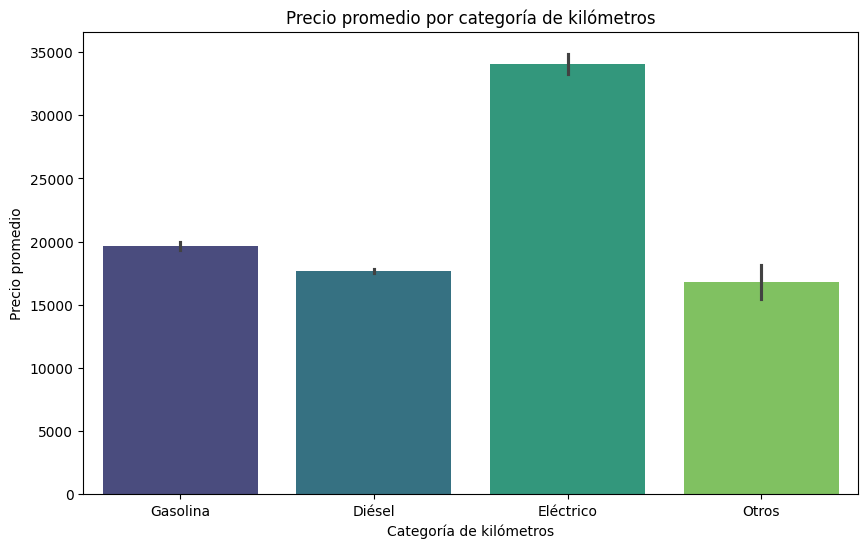

In [60]:
#Precio promedio segun categoria de kms.
plt.figure(figsize=(10, 6))
sns.barplot(data=df_final, x='fuel', y='price',palette='viridis')
plt.title('Precio promedio por categoría de kilómetros')
plt.xlabel('Categoría de kilómetros')
plt.ylabel('Precio promedio')
plt.show()

### Shift Type

C:\Users\Germán\AppData\Local\Temp\ipykernel_40560\3454441385.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final, x='shift', y='price',palette='viridis')


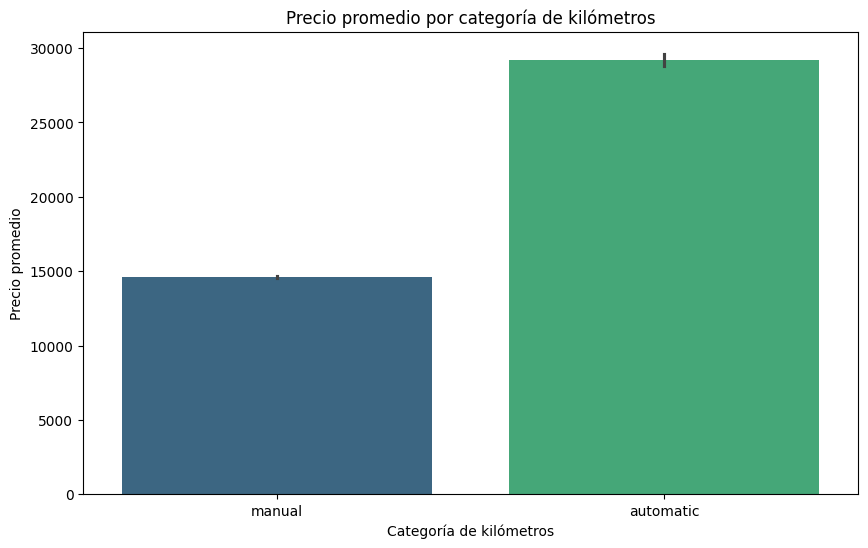

In [61]:
#Precio promedio segun categoria de kms. grafica
plt.figure(figsize=(10, 6))
sns.barplot(data=df_final, x='shift', y='price',palette='viridis')
plt.title('Precio promedio por categoría de kilómetros')
plt.xlabel('Categoría de kilómetros')
plt.ylabel('Precio promedio')
plt.show()

### Power

In [65]:
#Generar rangos de power y mostrar cuantos coches hay en cada rango
df_final['power_range'] = pd.cut(df_final['power'], bins=[0, 100, 200, 300, 400, 500, float("inf")], labels=['0-100', '100-200', '200-300', '300-400', '400-500', '500+'])
print(df_final['power_range'].value_counts())

power_range
100-200    27814
0-100      10138
200-300     2447
300-400     1007
400-500      565
500+         380
Name: count, dtype: int64


C:\Users\Germán\AppData\Local\Temp\ipykernel_40560\1899876350.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, x='power_range', palette='viridis')


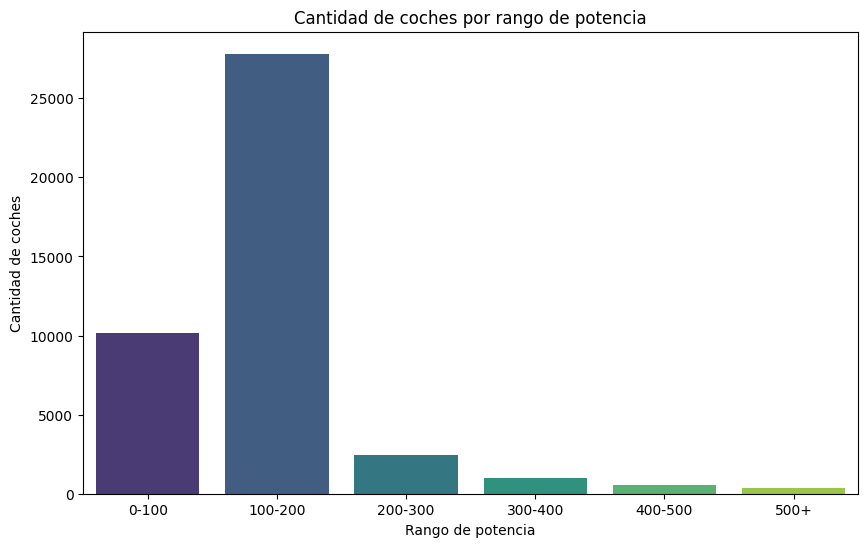

In [66]:
#Grafico de barras de la cantidad de coches por rango de potencia
plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='power_range', palette='viridis')
plt.title('Cantidad de coches por rango de potencia')
plt.xlabel('Rango de potencia')
plt.ylabel('Cantidad de coches')
plt.show()

### Year

C:\Users\Germán\AppData\Local\Temp\ipykernel_40560\3217641251.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_final, x='year', y='price', palette='viridis')


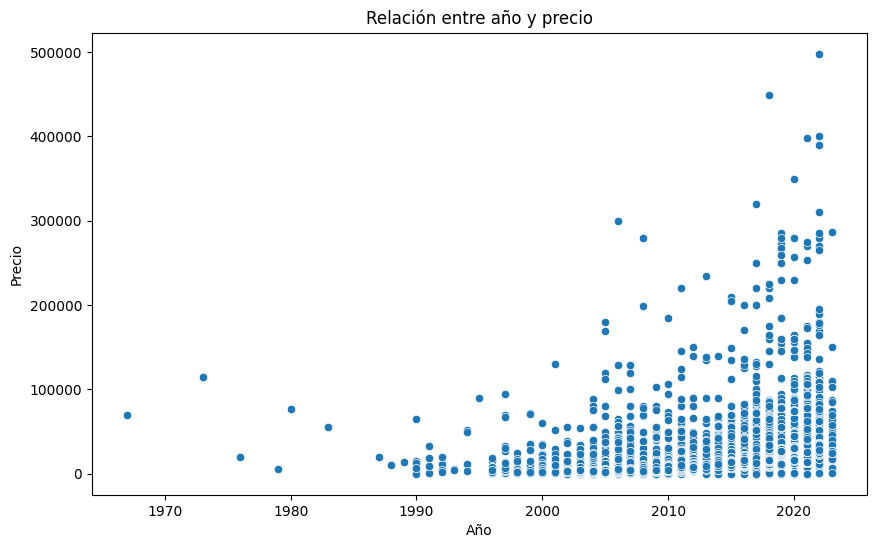

In [62]:
#Relacion entre year y precio 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='year', y='price', palette='viridis')
plt.title('Relación entre año y precio')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.show()

### Precios medios por provincia 

C:\Users\Germán\AppData\Local\Temp\ipykernel_40560\2605619257.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final, x='state', y='price',palette='viridis')


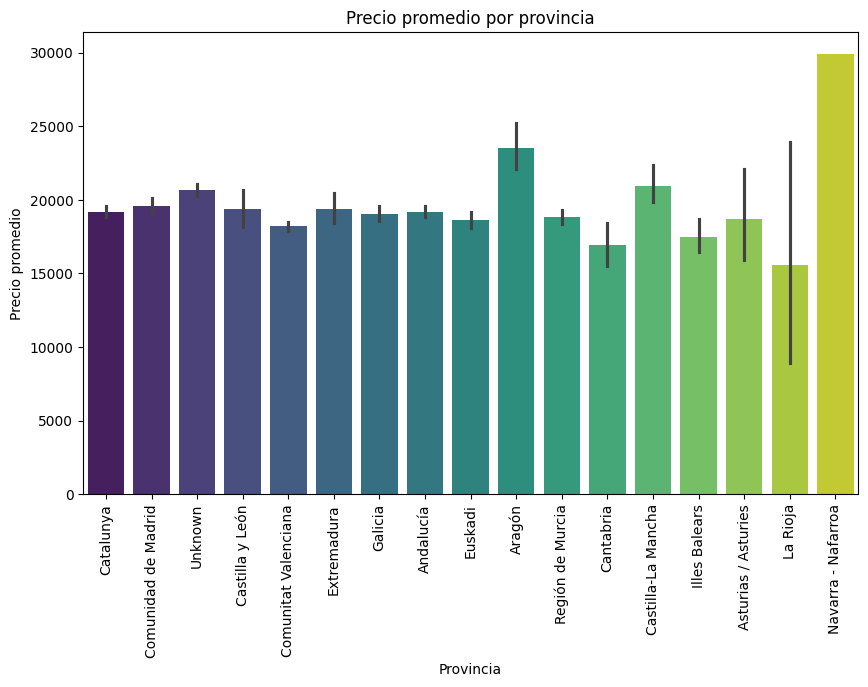

In [63]:
#Precio promedio segun provincia
plt.figure(figsize=(10, 6))
sns.barplot(data=df_final, x='state', y='price',palette='viridis')
plt.title('Precio promedio por provincia')
plt.xlabel('Provincia')
plt.ylabel('Precio promedio')
plt.xticks(rotation=90)
plt.show()

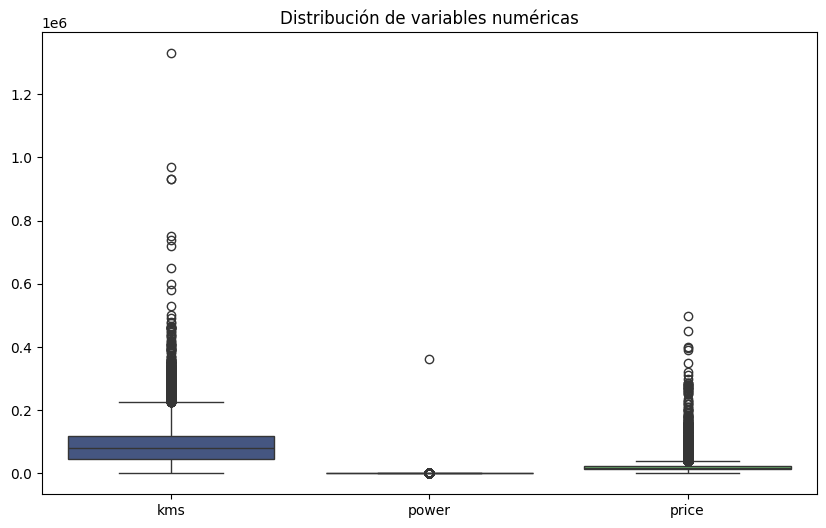

In [64]:
#Boxplot de variables numericas
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final[['kms', 'power', 'price']], palette='viridis')
plt.title('Distribución de variables numéricas')
plt.show()

### Diagrama con estimacion de densidad

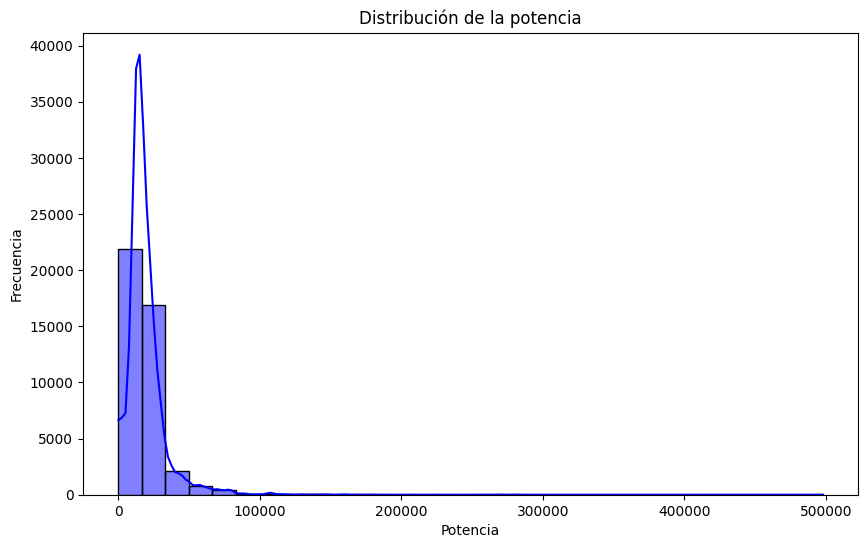

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_final['price'], kde=True, color='blue', bins=30)
plt.title('Distribución de la potencia')
plt.xlabel('Potencia')
plt.ylabel('Frecuencia')
plt.show()